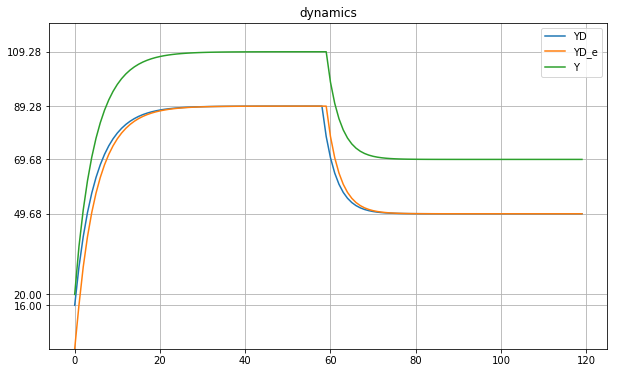

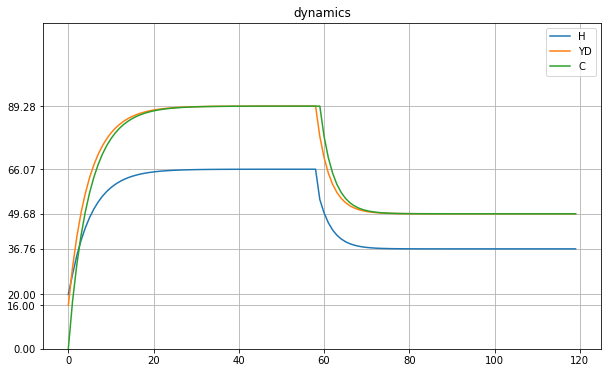

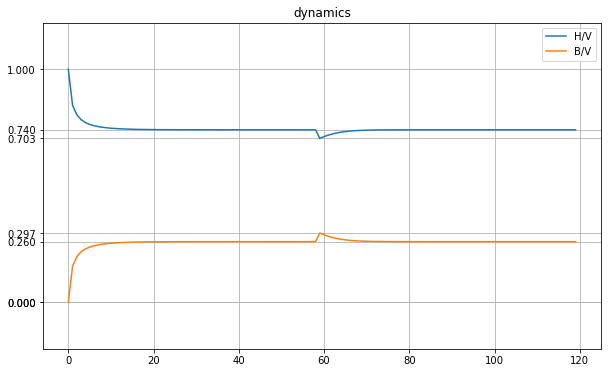

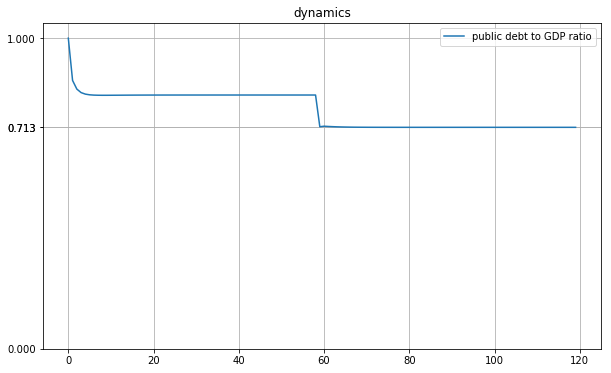

Enter the period to show the balance sheet and transaction matrix:2

Balance Sheet at period:  1
                    Household    Production    Government    Central Bank    Sum
------------------  -----------  ------------  ------------  --------------  -----
Money               27.46        0.00          0.00          -27.46          0.00
Bills               5.02         0.00          -32.48        27.46           0.00
Balance(net worth)  -32.48       0.00          32.48         0.00            0.00
sum                 0.00         0.00          0.00          0.00            0.00

Transaction flow matrix at period:  1
--------------------  ---------  ----------  ----------  ------------  ------------  -----
                                                         Central Bank  Central Bank
                      Household  Production  Government  Current       Capital       Sum
__________________    _________  _________   _________   _________     _________     _____
Consumption      

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  7 21:14:26 2017
Last modified on Wed Jun  7 21:14:26 2017

@author: xli

@email: xihao.li@gmail.com
"""

#### Model PCEX = PC + Expectation ####
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 6

"""
Methods used in the following codes
"""
Error_tolerance = 0.001;

def round_2(n1 ):
    if np.isscalar(n1):
        return np.round(  int( n1*1000 ) /1000, 2 );
    else:
        n2 = np.array(n1) * 1000;
        return np.round(  n2.astype(int) /1000, 2 );


def scalar_approximate_equal(n1, n2):
    if np.isscalar(n1) and np.isscalar(n2):
        if n2 != 0:
            return (abs(n1/n2 - 1) < Error_tolerance)
        elif n1 != 0:
            return (abs(n2/n1 - 1) < Error_tolerance)
        else:
            return True
    else:
        return False


"""
simulation parameter
"""
script_file_full_name = os.path.basename(sys.argv[0]);
script_file_name =  os.path.splitext(script_file_full_name)[0] + "_";
    
end_periods = 120
unit_test_activate = 0;
"""
Economic system variables
"""
theta = 0.2;
alpha_1 = 0.6;
alpha_2 = 0.4;

lambda_0 = 0.3; # portion of expected net worth going to Household's treasury bill demand
lambda_1 = 0.6; # sensitive parameter of Household's treasury bill demand 
                # on the rate of return on treasury bills

lambda_2 = 0.1; # sensitive parameter of Household's treasury bill demand 
                # on the level of disposable income relative to Household's net worth

class Households:
    """
    Stock variable in Balance Sheet
    """
    H = np.zeros((1, end_periods)); # Household's money demand
    B = np.zeros((1, end_periods)); # Household's treasury bill demand
    V = np.zeros((1, end_periods)); # Household's net worth
    """
    Flow variables in Transactions-flow matrix
    """   
    C = np.zeros((1, end_periods)); # Household's consumption demand
    Y = np.zeros((1, end_periods)); # Household's income in aggregate demand side
    YD = np.zeros((1, end_periods)); # Household's disposable income in aggregate demand side
    YD_e = np.zeros((1, end_periods)); # Household's expectation on disposable income in aggregate demand side
    V_e = np.zeros((1, end_periods)); # Household's expectation on Household's net worth
    T = np.zeros((1, end_periods)); # Household's tax supply
    delta_H = np.zeros((1, end_periods)); # change of Household's money demand
    delta_B = np.zeros((1, end_periods)); # change of Household's treasury bill demand
    
class Production:
    """
    Flow variables in Transactions-flow matrix
    """       
    C = np.zeros((1, end_periods)); # Production's consumption supply
    G = np.zeros((1, end_periods)); # Production's Government spending supply
    Y_e = np.zeros((1, end_periods)); # Production's expected production to sale
    Y = np.zeros((1, end_periods)); # Production's production in aggregate supply side

class CentralBank:
    """
    Stock variable in Balance Sheet
    """    
    H = np.zeros((1, end_periods)); # Central Bank's money supply
    B = np.zeros((1, end_periods)); # Central Bank's treasury bill demand
    """
    Flow variables in Transactions-flow matrix
    """     
    Profit = np.zeros((1, end_periods)); # Central Bank's profit
    delta_H = np.zeros((1, end_periods)); # change of Central Bank's money supply
    delta_B = np.zeros((1, end_periods)); # change of Central Bank's treasury bill demand

class Government:
    """
    Stock variable in Balance Sheet
    """    
    B = np.zeros((1, end_periods)); # Government's treasury bill supply
    V = np.zeros((1, end_periods)); # Government's net worth    
    """
    Flow variables in Transactions-flow matrix
    """   
    G = np.zeros((1, end_periods)); # Government's spending demand
    CB_Profit = np.zeros((1, end_periods)); # Government's receiving Central Bank's profit
    T = np.zeros((1, end_periods)); # Government's tax demand
    delta_B = np.zeros((1, end_periods)); # change of Government's treasury bill supply
    """
    Economic variables
    """
    r = np.ones((1, end_periods)) * 0.1; # Government's government bill interest rate


#== initialize the value of YD[0] ==#
Government.G[0,0] = 20;
Government.B[0,0] = Government.G[0,0]; # Government issue treasury bill to support its government spending
CentralBank.B[0,0] = Government.B[0,0]; # Central Bank buys all treasury bill issued by government
CentralBank.H[0,0] = CentralBank.B[0,0];
Households.H[0,0] = CentralBank.H[0,0];
Households.V[0,0] = Households.H[0,0] + Households.B[0,0];
Government.V[0,0] = Government.B[0,0];


Households.Y[0,0] = Government.G[0,0] + Households.C[0,0]; # Y[0] = 20，C[0] = 0
Households.YD[0,0] = Households.Y[0,0] - theta * Households.Y[0,0];


for t in range(1,end_periods):  
    """
    Experiment:
    when t>= 60, increase tax rates (or reduce interest rate), 
    in order to reduce public debt to GDP ratio V/Y
    """
    if t>= 59:
        theta = 0.3;

    """
    Government decides its spending
    """
    Government.G[0,t] = Government.G[0,t-1];
    """
    Household makes expectation on disposable income: YD_e
    """
    Households.YD_e[0,t] = Households.YD[0,t-1]; # Household's expectation on its YD
    """
    Based on expectation, Household decides demand for consumption
    """
    Households.C[0,t] = alpha_1 * Households.YD_e[0,t] + alpha_2 * Households.V[0,t-1]; # Household's consumption demand, based on its expectation on    
    """
    Household makes expectation on net worth: V_e
    """    
    Households.V_e[0,t] = Households.V[0,t-1] + ( Households.YD_e[0,t] - Households.C[0,t] ); # expectational rule of Household's net worth 
    """
    Based on expectation, Household decides demand for treasury bill, 
    demand for money: B and H. First decide B, then the residual goes to H
    """
    Households.B[0,t] = lambda_0 * Households.V_e[0,t] + lambda_1 * Government.r[0,t] * Households.V_e[0,t] - lambda_2 * Households.YD_e[0,t];
    Households.H[0,t] = Households.V_e[0,t] - Households.B[0,t];
    """
    Production realizes supply = demand
    """
    Production.Y_e[0,t] = Government.G[0,t] + Households.C[0,t];
    Production.Y[0,t] = Production.Y_e[0,t];
    Production.G[0,t] = Government.G[0,t];
    Production.C[0,t] = Households.C[0,t];    
    """
    Household realizes its production, tax payment                                       
    """
    Households.Y[0,t] = Production.Y[0,t];
    Households.T[0,t] = theta * ( Households.Y[0,t] + Government.r[0,t-1] * Households.B[0,t-1] );
    """
    Government collects tax
    """
    Government.T[0,t] = Households.T[0,t];
    """
    Household realizes its disposable income and net worth                                 
    """
    Households.YD[0,t] = Households.Y[0,t] - Households.T[0,t] + Government.r[0,t-1] * Households.B[0,t-1];
    Households.V[0,t] = Households.V[0,t-1] + ( Households.YD[0,t] - Households.C[0,t] );
    """
    Household adjusts, at the end of period, any discrepency 
    between realized net worth and treasury bill demand, 
    putting it as money demand 
    """
    Households.H[0,t] = Households.V[0,t] - Households.B[0,t]; 
    Households.delta_H[0,t] = Households.H[0,t] - Households.H[0,t-1];
    """
    Government decides its new level of treasury bill    
    """
    CentralBank.Profit[0,t] = Government.r[0,t-1] * CentralBank.B[0,t-1];
    Government.CB_Profit[0,t] = CentralBank.Profit[0,t];    
    Government.delta_B[0,t] = (Government.G[0,t] + Government.r[0,t-1] * Government.B[0,t-1]) - (Government.T[0,t] + Government.CB_Profit[0,t]);
    Government.B[0,t] = Government.B[0,t-1] + Government.delta_B[0,t];
    Government.V[0,t] = Government.B[0,t];    
    """
    CentralBank collects the residual of treasury bill in the market:
    the difference between Government's bill supply and Household's bill demand
    """
    CentralBank.B[0,t] = Government.B[0,t] - Households.B[0,t];
    """
    CentraBank decides its new level of money supply based on its change of treasury bill bought in
    """    
    CentralBank.delta_B[0,t] = CentralBank.B[0,t] - CentralBank.B[0,t-1];
    CentralBank.delta_H[0,t] = CentralBank.delta_B[0,t];
    CentralBank.H[0,t] = CentralBank.H[0,t-1] + CentralBank.delta_H[0,t];
    """
    Household computes its change of treasury bill, to check stock-flow consistency 
    """
    Households.delta_B[0,t] = Households.B[0,t] - Households.B[0,t-1];
    
    # unit test on stock-flow consistency
    if unit_test_activate == 1:
        if scalar_approximate_equal( Government.delta_B[0,t] , Households.delta_B[0,t] + CentralBank.delta_B[0,t] ):
            print('Consistency check: change of Bill supply == change of Bill demand');
        else:
            print('Warning! change of Bill supply == change of Bill demand INconsistency!'); 

# plot Household expectation on disposable income, realized disposable income, 
# and total income == GDP in demand side
plot_period = end_periods + 1
plt.figure(1)
plt.plot(Households.YD[0,:], label = 'YD')
plt.plot(Households.YD_e[0,:], label = 'YD_e')
plt.plot(Households.Y[0,:], label = 'Y')
plt.title('dynamics')
plt.legend(['YD', 'YD_e', 'Y'], loc=0) # legend automatically in the best location
plt.ylim(0, 110)
extraticks=[Households.YD[0,end_periods-1], np.min(Households.YD[0,:]), np.max(Households.YD[0,:]), Households.Y[0,end_periods-1], np.min(Households.Y[0,:]), np.max(Households.Y[0,:]) ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_01.jpg') 
plt.show()

# plot Household money stock, disposable income, consumption

plot_period = end_periods + 1
plt.figure(2)
plt.plot(Households.H[0,:], label = 'H')
plt.plot(Households.YD[0,:], label = 'YD')
plt.plot(Households.C[0,:], label = 'C')
plt.title('dynamics')
plt.legend(['H', 'YD', 'C'], loc=0) # legend automatically in the best location
plt.ylim(0, 110)
extraticks=[0.0, np.min(Households.H[0,:]), np.max(Households.H[0,:]),  Households.H[0,end_periods-1], Households.YD[0,end_periods-1], np.min(Households.YD[0,:]), np.max(Households.YD[0,:]) ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_02.jpg') 
plt.show()

# plot Household share of money stock and treasury bills
plot_period = end_periods + 1
plt.figure(3)
plt.plot(Households.H[0,:]/ Households.V[0,:], label = 'H/V')
plt.plot(Households.B[0,:]/ Households.V[0,:], label = 'B/V')
plt.title('dynamics')
plt.legend(['H/V', 'B/V'], loc=0) # legend automatically in the best location
extraticks=[0.0, Households.H[0,end_periods-1]/Households.V[0,end_periods-1], np.min(Households.H[0,:]/Households.V[0,:]), np.max(Households.H[0,:]/Households.V[0,:]), Households.B[0,end_periods-1]/Households.V[0,end_periods-1], np.min(Households.B[0,:]/Households.V[0,:]), np.max(Households.B[0,:]/Households.V[0,:]) ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_03.jpg') 
plt.show()


# plot the economy's public debt to GDP ratio: V/Y, V: the wealth of Household, equal to the debt owed by Government
plot_period = end_periods + 1
plt.figure(4)
plt.plot(Households.V[0,:]/ Households.Y[0,:], label = 'V/Y')
plt.title('dynamics')
plt.legend(['public debt to GDP ratio'], loc=0) # legend automatically in the best location
extraticks=[0.0, Households.V[0,end_periods-1]/Households.Y[0,end_periods-1], np.min(Households.V[0,:]/Households.Y[0,:]), np.max(Households.V[0,:]/Households.Y[0,:])  ]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.yticks(extraticks)
plt.grid()
plt.savefig(script_file_name + 'fig_04.jpg') 
plt.show()

while True:
    table_periods = int(input('Enter the period to show the balance sheet and transaction matrix:'))
    if table_periods > end_periods + 1:
        table_periods = end_periods;

    table_periods = 2;
    BS_headers = [" ", "Household", "Production", "Government", "Central Bank", "Sum"]
    # balance sheet table
    bs_table = [["Money", Households.H[0,table_periods-1], 0.0, 0.0, - CentralBank.H[0,table_periods-1], sum( [ Households.H[0,table_periods-1], - CentralBank.H[0,table_periods-1] ] )], 
                ["Bills", Households.B[0,table_periods-1], 0, - Government.B[0,table_periods-1], + CentralBank.B[0,table_periods-1], sum([ Households.B[0,table_periods-1], 0, - Government.B[0,table_periods-1], + CentralBank.B[0,table_periods-1] ])  ],
                ["Balance(net worth)", - Households.V[0,table_periods-1], 0.0, +Government.V[0,table_periods-1], 0.0 , sum([ - Households.V[0,table_periods-1], 0.0, +Government.V[0,table_periods-1]  ])  ],
                ["sum", sum([ Households.H[0,table_periods-1],  Households.B[0,table_periods-1], - Households.V[0,table_periods-1] ]), 0.0, sum( [ - Government.B[0,table_periods-1], +Government.V[0,table_periods-1] ] ), sum([- CentralBank.H[0,table_periods-1], + CentralBank.B[0,table_periods-1]  ]), sum([sum([ Households.H[0,table_periods-1],  Households.B[0,table_periods-1], - Households.V[0,table_periods-1] ]), 0.0, sum( [ - Government.B[0,table_periods-1], +Government.V[0,table_periods-1] ] ), sum([- CentralBank.H[0,table_periods-1], + CentralBank.B[0,table_periods-1]  ]) ])  ]
                ]
    print("\nBalance Sheet at period: ", table_periods-1)
    print(tabulate(bs_table, BS_headers, floatfmt=".2f", numalign="left") )
    
    # transaction flow table
    tf_headers = [" ",  " ", " ",  " ", "Central Bank", "Central Bank", " "];
    
    sum_row_1 = round_2( sum( [ round_2(-Households.C[0,table_periods-1]), round_2(+Production.C[0,table_periods-1]) ] ) );
    sum_row_2 = round_2( sum( [ round_2(+Production.G[0,table_periods-1]), round_2(-Government.G[0,table_periods-1]) ] ) );
    sum_row_3 = round_2( sum( [ round_2( Households.Y[0,table_periods-1] ), round_2( -Production.Y[0,table_periods-1] ) ] ) );
    sum_row_4 = round_2( sum( [ round_2(+ Government.r[0,table_periods-1-1] * Households.B[0,table_periods-1-1] ), round_2(- Government.r[0,table_periods-1-1] * Government.B[0,table_periods-1-1] ), round_2(+ Government.r[0,table_periods-1-1] * CentralBank.B[0,table_periods-1-1] ) ] ) );
    sum_row_5 = round_2( sum( [ round_2( + Government.CB_Profit[0,table_periods -1] ), round_2( -CentralBank.Profit[0,table_periods-1] ) ] ) );
    sum_row_6 = round_2( sum( [ round_2(-Households.T[0,table_periods-1]), round_2(+Government.T[0,table_periods-1]) ] ) );
    sum_row_7 = round_2( sum( [ round_2(-Households.delta_H[0,table_periods-1]), round_2(+CentralBank.delta_H[0,table_periods-1]) ] ) );
    sum_row_8 = round_2( sum( [ round_2( -Households.delta_B[0,table_periods-1] ), round_2( +Government.delta_B[0,table_periods-1] ), round_2( -CentralBank.delta_B[0,table_periods-1] ) ] ) );
    sum_column_1 = round_2( sum( round_2( [ -Households.C[0,table_periods-1], Households.Y[0,table_periods-1], + Government.r[0,table_periods-1-1] * Households.B[0,table_periods-1-1], -Households.T[0,table_periods-1] , -Households.delta_H[0,table_periods-1], -Households.delta_B[0,table_periods-1]  ] ) ) );
    sum_column_2 = round_2( sum( round_2( [ Production.C[0,table_periods-1], Production.G[0,table_periods-1], - Production.Y[0,table_periods-1] ] ) ) );
    sum_column_3 = round_2( sum( round_2( [ -Government.G[0,table_periods-1], - Government.r[0,table_periods-1-1] * Government.B[0,table_periods-1-1] , + Government.CB_Profit[0,table_periods-1], + Government.T[0,table_periods-1], + Government.delta_B[0,table_periods-1]  ]  ) ) );
    sum_column_4 = round_2( sum( round_2( [ +Government.r[0,table_periods-1-1] * CentralBank.B[0,table_periods-1-1] , - CentralBank.Profit[0,table_periods-1] ] ) ) );
    sum_column_5 = round_2( sum( round_2( [ +CentralBank.delta_H[0,table_periods-1], - CentralBank.delta_B[0,table_periods-1]   ] ) ) );
    sum_all_columns = round_2(sum( [sum_column_1, sum_column_2, sum_column_3, sum_column_4, sum_column_5] ));
    
    tf_table = [[" ",  " ", " ",  " ", "Central Bank", "Central Bank", " "],
                [" ", "Household", "Production", "Government", " Current ", " Capital ", "Sum"],
                [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____" ],
                ["Consumption", round_2(-Households.C[0,table_periods-1]), round_2(+Production.C[0,table_periods-1]), " ", " ", " ", sum_row_1 ],
    ["Govt. expenditures", " " , round_2(+Production.G[0,table_periods-1]), round_2(-Government.G[0,table_periods-1]), " ", " ",  sum_row_2 ],
    ["Income = GDP", round_2( Households.Y[0,table_periods-1] ), round_2( -Production.Y[0,table_periods-1] ),  " ", " ", " ", sum_row_3 ],
    ["Interest payments", round_2(+ Government.r[0,table_periods-1-1] * Households.B[0,table_periods-1-1] ), " ", round_2(- Government.r[0,table_periods-1-1] * Government.B[0,table_periods-1-1] ), round_2(+ Government.r[0,table_periods-1-1] * CentralBank.B[0,table_periods-1-1] ),  " ", sum_row_4 ],
    ["Central bank profits", " ", " ", round_2( + Government.CB_Profit[0,table_periods -1] ), round_2( -CentralBank.Profit[0,table_periods-1] ), " ", sum_row_5 ],
    ["Taxes", round_2(-Households.T[0,table_periods-1]), " ", round_2(+Government.T[0,table_periods-1]), " ", " ", sum_row_6 ],
    ["Change in money", round_2(-Households.delta_H[0,table_periods-1]), " ", " ", " ", round_2(+CentralBank.delta_H[0,table_periods-1]), sum_row_7 ],
    ["Change in bills", round_2( -Households.delta_B[0,table_periods-1] ), " ", round_2( +Government.delta_B[0,table_periods-1] ), " ", round_2( -CentralBank.delta_B[0,table_periods-1] ), sum_row_8 ],
    [ "__________________", "_________", "_________", "_________", "_________", "_________", "_____" ],
    ["sum", sum_column_1, sum_column_2, sum_column_3, sum_column_4, sum_column_5, sum_all_columns ] 
    ]
    print("\nTransaction flow matrix at period: ", table_periods-1)
    print(tabulate(tf_table, floatfmt=".2f", numalign="left"))

    answer = input('Do you want to continue?:')
    if answer.lower().startswith("n"):
      print("ok, bye!")
      break

